In [1]:
import socket
from time import time
import argparse
from hyperbolicity.utils import soft_max, floyd_warshall, soft_max, construct_weighted_matrix, make_batches
import torch
import torch.optim as optim
import networkx as nx
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from tqdm import tqdm
from hyperbolicity.delta import compute_hyperbolicity_batch, compute_hyperbolicity
from hyperbolicity.far_apart_points import filter_farapart
import pickle
import os
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from transformers import Adafactor
import numpy as np
import pandas as pd

In [2]:
import numpy as np
from scipy.spatial import distance as ssd
from scipy.cluster.hierarchy import linkage

def linkage_to_distance_matrix(Z):
    """
    Converts a linkage matrix Z (from scipy.cluster.hierarchy.linkage)
    into a full pairwise distance matrix D of shape (n, n), where n is the number of leaves.
    """
    N = Z.shape[0] + 1
    clusters = [[i] for i in range(N)]
    D = np.zeros((N, N))
    for i in range(N - 1):
        j, k = int(Z[i, 0]), int(Z[i, 1])
        for x in clusters[j]:
            for y in clusters[k]:
                D[x, y] = D[y, x] = Z[i, 2]
        clusters.append(clusters[j] + clusters[k])
    return D

def gromov_tree(distance_matrix, root):
    """
    Computes a Gromov-style distance matrix from a given root using a hierarchical clustering
    approximation based on the induced ultrametric.

    Parameters:
        distance_matrix (np.ndarray): Original pairwise distance matrix.
        root (int): Index to use as the root node.

    Returns:
        np.ndarray: Gromov-adjusted distance matrix (tree-metric approximation).
    """
    n = distance_matrix.shape[0]
    d_root = distance_matrix[root]
    d_max = d_root.max()
    
    gp = np.tile(d_root, (n, 1)) + np.tile(d_root.reshape(n, 1), (1, n)) - distance_matrix
    gp /= 2.0

    d_U = d_max - gp
    np.fill_diagonal(d_U, 0)

    Z = linkage(ssd.squareform(d_U), method='single')
    D_gromov = linkage_to_distance_matrix(Z)

    gp_T = d_max - D_gromov
    d_T = np.tile(d_root, (n, 1)) + np.tile(d_root.reshape(n, 1), (1, n)) - 2.0 * gp_T
    np.fill_diagonal(d_T, 0)

    return d_T


In [3]:
base_path = '/share/home/houedry/projects/hyperbolic/DifferentiableHyperbolicity/hyperbolicity/datasets'

c_elegan = 'D_celegan.pkl'
c_elegan_path = os.path.join(base_path, c_elegan)
with open(c_elegan_path, 'rb') as f:
    distances = pickle.load(f)
distances = torch.tensor(distances).to('cuda').type(torch.float32)

In [ ]:
def train_distance_matrix(distances: torch.Tensor,
                          scale_sp: float,
                          scale_delta: float,
                          scale_soft_max: float,
                          distance_reg: float,
                          num_epochs: int,
                          n_batches: int,
                          batch_size: int,
                          learning_rate: float,
                          verbose: bool):

    num_nodes = distances.shape[0]
    edges = torch.triu_indices(num_nodes, num_nodes, offset=1)
    upper_adjency = torch.triu(distances, diagonal=1).type(torch.float32)
    true_upper = upper_adjency[upper_adjency != 0].to('cuda')
    weights_opt = true_upper.requires_grad_(True)
    optimizer = optim.Adam([weights_opt], lr=learning_rate)
    losses = []
    deltas = []
    errors = []


    def projection(weight, num_nodes, edges):
        update_dist = construct_weighted_matrix(weight, num_nodes, edges)
        update_dist = floyd_warshall(update_dist)
        #idx, pairs = filter_farapart(update_dist)

        return torch.triu(update_dist, diagonal=1)[torch.triu(update_dist, diagonal=1) != 0]#, pairs

    def loss_fn(w):
        update_dist = construct_weighted_matrix(w, num_nodes, edges)
        M_batch = make_batches(update_dist, size_batches=batch_size, nb_batches=n_batches)
        #delta = soft_max(compute_hyperbolicity_batch(M_batch, scale=scale_delta), scale=scale_soft_max)
        delta = compute_hyperbolicity_batch(M_batch, scale=scale_delta)
        print(delta.shape)
        err = (true_upper-w).pow(2).sum()
        #err = soft_max(torch.abs(distances.flatten()-update_dist.flatten()), scale=scale_soft_max)

        return delta + distance_reg*err, delta, err

    with tqdm(range(num_epochs), desc="Training Weights", disable=not verbose) as pbar:
        for epoch in pbar:
            optimizer.zero_grad()
            loss, delta, err = loss_fn(weights_opt)

            pbar.set_description(f"loss = {loss.item():.5f}, delta = {delta:.5f}, error = {err:.5f}")
            if torch.isnan(loss):
                raise NanError('Loss is Nan')
            losses.append(loss.item())
            deltas.append(delta.item())
            errors.append(err.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_([weights_opt], max_norm=1.0)
            optimizer.step()

            with torch.no_grad():
                weights_opt.data = projection(weights_opt, num_nodes, edges)


    return weights_opt.detach().clone(), losses, deltas, errors

In [7]:
scale = 10000
distance_reg = 0.01
num_epochs = 300
batch_size = 25
n_batches = 50
learning_rate = 0.01


weights, losses, deltas, errors = train_distance_matrix(distances,
                                                scale_sp=scale,
                                                scale_delta=scale,
                                                scale_soft_max=scale,
                                                distance_reg=distance_reg,
                                                num_epochs=num_epochs,
                                                batch_size=batch_size,
                                                n_batches=n_batches,
                                                learning_rate=learning_rate,
                                                verbose=True)

Training Weights:   0%|          | 0/300 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacity of 10.75 GiB of which 141.62 MiB is free. Process 4165648 has 628.00 MiB memory in use. Process 2863717 has 9.16 GiB memory in use. Including non-PyTorch memory, this process has 862.00 MiB memory in use. Of the allocated memory 677.21 MiB is allocated by PyTorch, and 6.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

LSE
scale = 10000
distance_reg = 0.01
num_epochs = 300
batch_size = 30
n_batches = 55
learning_rate = 0.01


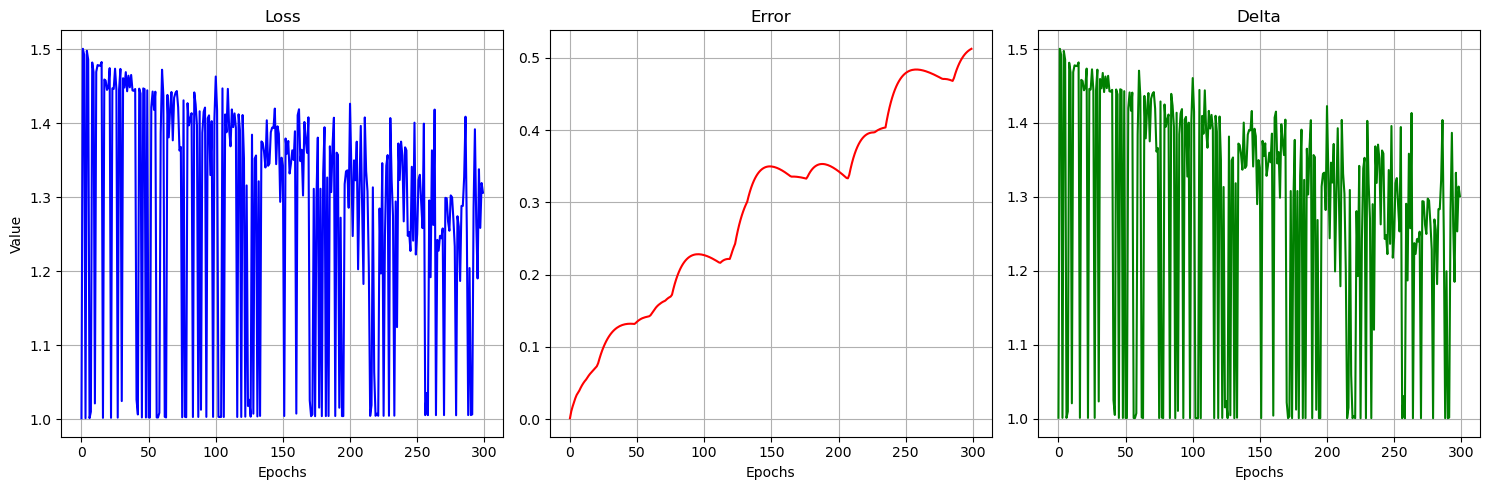

In [ ]:
print('LSE')
print(f"scale = {scale}")
print(f"distance_reg = {distance_reg}")
print(f"num_epochs = {num_epochs}")
print(f"batch_size = {batch_size}")
print(f"n_batches = {n_batches}")
print(f"learning_rate = {learning_rate}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(losses, label='Loss', color='blue')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Value')
axs[0].grid()

axs[1].plot(errors, label='Error', color='red')
axs[1].set_title('Error')
axs[1].set_xlabel('Epochs')
axs[1].grid()

axs[2].plot(deltas, label='Delta', color='green')
axs[2].set_title('Delta')
axs[2].set_xlabel('Epochs')
axs[2].grid()
plt.tight_layout()


In [ ]:
num_nodes = distances.shape[0]
edges = torch.triu_indices(num_nodes, num_nodes, offset=1)
intermediate_distances = construct_weighted_matrix(weights, num_nodes, edges)

In [ ]:
mean_optim = []
l1_error_optim = []
for j in range(distances.shape[0]):
    tree_optim = gromov_tree(intermediate_distances.cpu().numpy(), j)
    mean_optim.append(np.abs(tree_optim - distances.cpu().numpy()).max())
    l1_error_optim.append((2/(num_nodes*(num_nodes-1)))*np.abs(tree_optim - distances.cpu().numpy()).sum())

In [ ]:
mean_optim_value = np.mean(mean_optim)
min_optim_value = np.min(mean_optim)
print(f"Mean Optimized: {mean_optim_value:.4f}, Std Dev Optimized: {np.std(mean_optim):.4f}")
print(f"Minimum Optimized: {min_optim_value:.4f}")
mean_l1_error_optim = np.min(l1_error_optim)
print(f"Min L1 Error Optimized: {mean_l1_error_optim:.4f}")

Mean Optimized: 3.3217, Std Dev Optimized: 0.3811
Minimum Optimized: 3.0000
Min L1 Error Optimized: 2.0111


In [ ]:
torch.abs(intermediate_distances - distances).max(), torch.abs(intermediate_distances - distances).mean()

(tensor(0.3483, device='cuda:0'), tensor(0.0147, device='cuda:0'))

In [ ]:
l1_error_no_optim = []
mean_no_optim = []
for j in range(distances.shape[0]):
    tree_no_optim = gromov_tree(distances.cpu().numpy(), j)
    mean_no_optim.append(np.abs(tree_no_optim - distances.cpu().numpy()).max())
    l1_error_no_optim.append((2/(num_nodes*(num_nodes-1)))*np.abs(tree_no_optim - distances.cpu().numpy()).sum())


In [ ]:
mean_no_optim_value = np.mean(mean_no_optim)
print(f"Mean No Optimized: {mean_no_optim_value:.4f}, Std Dev No Optimized: {np.std(mean_no_optim):.4f}")
print(f"Minimum No Optimized: {np.min(mean_no_optim):.4f}")
mean_l1_error_no_optim = np.min(l1_error_no_optim)
print(f"Min L1 Error No Optimized: {mean_l1_error_no_optim:.4f}")

Mean No Optimized: 3.3274, Std Dev No Optimized: 0.4693
Minimum No Optimized: 3.0000
Min L1 Error No Optimized: 1.9944
